# Super-Converge 

LR range test

In [2]:
import sys
sys.path.append('..')
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
%load_ext autoreload
%autoreload 2

# library import 

In [4]:
import torch as t
import torch.nn as nn
import os
import argparse
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from ExpUtils import *

t.backends.cudnn.benchmark = True
t.backends.cudnn.enabled = True
seed = 1
inner_his = []

In [5]:
args = argparse.Namespace()
args.batch_size = 64
args.buffer_size = 10000
args.data_root = "../data"
args.dataset = "cifar10"
args.debug = True
args.decay_epochs = [35, 80, 120]
args.decay_rate = 0.1
args.dropout_rate = 0.0
args.load_path = "temp.pt"
args.log_dir = "./runs"
args.lr = 0.0001
args.n_classes = 10
args.n_epochs = 150

# model resnet56

In [6]:
import torch.nn.functional as F

class BasicBlock(nn.Module):
    
    def __init__(self, ch_in, ch_out, stride=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(ch_out)
        self.conv1 = nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ch_out)
        self.conv2 = nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or ch_in != ch_out:
            self.shortcut = nn.Sequential(
                nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(ch_out)
            )

    def forward(self, x):
        shortcut = self.shortcut(x) if hasattr(self, 'shortcut') else x
        out = self.conv1(x)
        out = self.bn2(self.conv2(F.relu(self.bn1(out))))
        out += shortcut
        return F.relu(out)

    
class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self.make_group_layer(16, 16, num_blocks[0], stride=1)
        self.layer2 = self.make_group_layer(16, 32, num_blocks[1], stride=2)
        self.layer3 = self.make_group_layer(32, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def make_group_layer(self,ch_in, ch_out, num_blocks, stride):
        layers = [BasicBlock(ch_in, ch_out, stride)]
        for i in range(num_blocks-1):
            layers.append(BasicBlock(ch_out, ch_out, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        return F.log_softmax(self.linear(out), dim=1)

# load data

In [9]:
from utils import get_data
args.batch_size = 512
train_loader, test_loader = get_data(args)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args.device = device

Files already downloaded and verified
Files already downloaded and verified


# Learning rate range test

!pip install torch_lr_finder

In [10]:
from torch_lr_finder import LRFinder

## Adam

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.85E-04


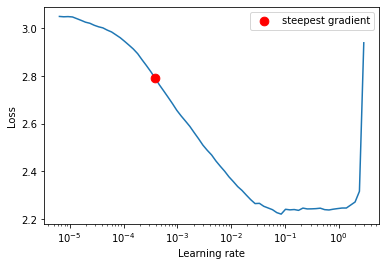

In [15]:
net = ResNet([9, 9, 9])  # 9,9,9 in the github repo or  9, 8, 8 in paper?
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = t.optim.Adam(net.parameters(), lr=1e-6, weight_decay=1e-4)
lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

## SGD

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.38E+00


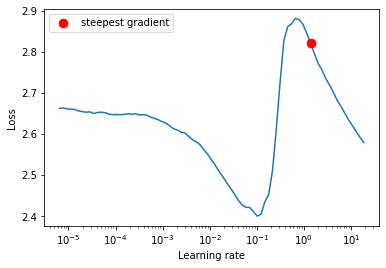

In [16]:
net = ResNet([9, 9, 9])  # 9,9,9 in the github repo or  9, 8, 8 in paper?
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = t.optim.SGD(net.parameters(), lr=1e-6, weight_decay=1e-4)
lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

## SGD, start lr = 0.5

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.54E-01


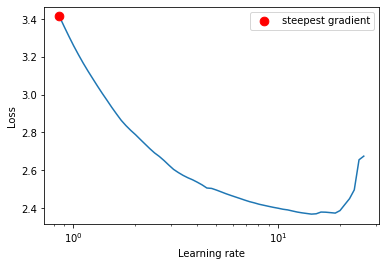

In [17]:
net = ResNet([9, 9, 9])  # 9,9,9 in the github repo or  9, 8, 8 in paper?
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = t.optim.SGD(net.parameters(), lr=0.5, weight_decay=1e-4)
lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

## SGD start lr = 0.1

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.04E-01


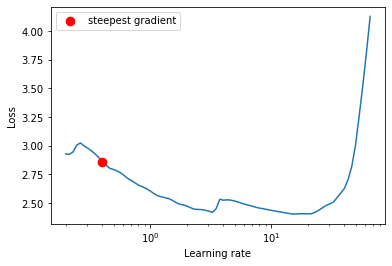

In [18]:
net = ResNet([9, 9, 9])  # 9,9,9 in the github repo or  9, 8, 8 in paper?
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = t.optim.SGD(net.parameters(), lr=0.1, weight_decay=1e-4)
lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

## Adam, test data

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.43E-06


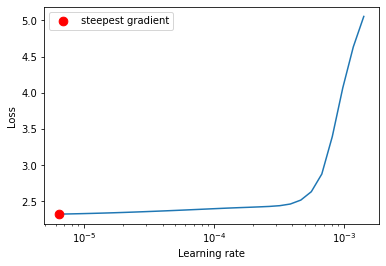

In [20]:
net = ResNet([9, 9, 9])  # 9,9,9 in the github repo or  9, 8, 8 in paper?
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = t.optim.Adam(net.parameters(), lr=1e-6, weight_decay=4e-4)
lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=100, num_iter=100, step_mode="exp")
lr_finder.plot()


Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.59E-02


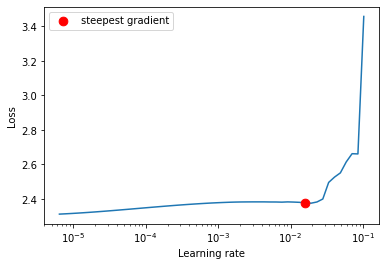

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1b80039208>,
 0.01592282793341094)

In [21]:
net = ResNet([9, 9, 9])  # 9,9,9 in the github repo or  9, 8, 8 in paper?
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = t.optim.SGD(net.parameters(), lr=1e-6, weight_decay=4e-4)
lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=100, num_iter=100, step_mode="exp")
lr_finder.plot()
